# Exploring a redesign of the snowexsql database

This notebook works with a toy database located on AWS to explore what could be possible with a redesign of the [NASA Snowexsql](https://github.com/SnowEx/snowexsql) database.

(We're calling the propsed redesign "beaver-db" because...we were initially using the [dbeaver](https://dbeaver.io/) database interface to try some things. Seemed like a good idea at the time...)

A. Arendt and J. Meyer

In [1]:
from snowexsql.db import get_db
from sqlalchemy import text
from sqlalchemy import inspect
import pandas as pd

### Connect to the existing snowexsql database 

We'll follow the great [database tutorials](https://snowex.hackweek.io/tutorials/database/index.html) by Micah$^2$ from the 2022 snowexhackweek.

In [2]:
db_snowex_engine = get_db('snow:hackweek@db.snowexdata.org/snowex')[0]
# Output the list of tables in the database 
tables = inspect(db_snowex_engine).get_table_names()
print(tables)

['spatial_ref_sys', 'points', 'layers', 'sites', 'images']


### The entity relationship diagram (ERD) for the current Snowexsql database

(generated using dbeaver software)

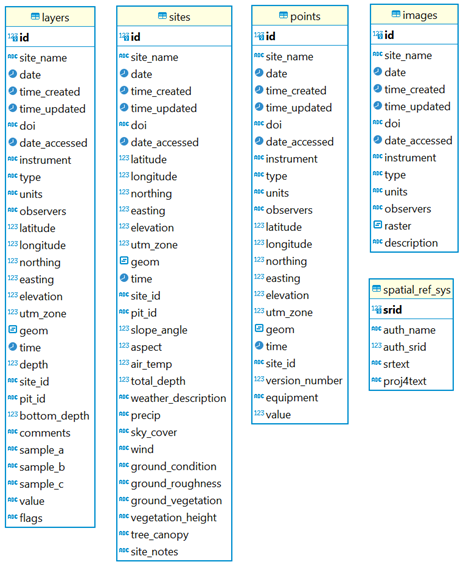

### Connect to the beaver-db database

We've temporarily created a free, micro instance of a postgres database on Amazon Relational Database System (RDS). It's open to any IP address at the moment.

In [3]:
db_beaver_engine = get_db('db-beaver.c64qrzqeobgb.us-west-2.rds.amazonaws.com', '../creds.json')[0]

### Run this to create the beaver-db database from a SQL script

Run this anytime you change the schema of the database in the sql file. If nothing changes you only need to run this once.

In [4]:
with open("../sql_scripts/layers_with_constraints.sql") as file:
    query = text(file.read())
    results = db_beaver_engine.execute(query)

### This is the entity relationship diagram for the test beaver-db database

For now we won't be working with any image data. Just trying some new things with the point and layer observations.

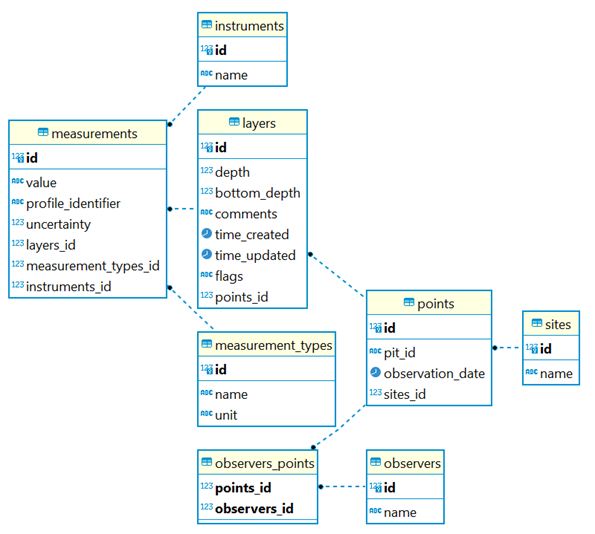

Now let's take a look at some data from the snowexsql database and think about how that might fit into our proposed new schema.

We'll do some tests with data described in the [Snowex mission and datasets tutorial](https://snowex.hackweek.io/tutorials/core-datasets/02_data_descriptions.html).

Suppose we want to work with the data shown in this fieldbook snippet:

![field-book-1](https://snowex.hackweek.io/_images/02_SnowEx20_SnowPits_GMIOP_20200212_2C12_book1_v01.jpg)

'Pit_ID' on the field book refers to 'site_id' in the database. Let's formulate a SQL query to look for any records with site_id = 2C12

In [5]:
qry = "SELECT * FROM layers WHERE site_id = '2C12' LIMIT 5"

For readability, let's read the data into a Pandas dataframe:

In [6]:
df = pd.read_sql(qry, db_snowex_engine)
df

,site_name,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,...,depth,site_id,pit_id,bottom_depth,comments,sample_a,sample_b,sample_c,value,flags
0,Grand Mesa,2020-02-12,2022-06-30 22:28:33.067228+00:00,None,6287,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,density,None,...,90.0,2C12,COGM2C12_20200212,80.0,None,None,None,None,195.0,None
1,Grand Mesa,2020-02-12,2022-06-30 22:28:33.067228+00:00,None,6288,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,density,None,...,80.0,2C12,COGM2C12_20200212,70.0,None,None,None,None,241.5,None
2,Grand Mesa,2020-02-12,2022-06-30 22:28:33.067228+00:00,None,6289,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,density,None,...,70.0,2C12,COGM2C12_20200212,60.0,None,None,None,None,297.0,None
3,Grand Mesa,2020-02-12,2022-06-30 22:28:33.067228+00:00,None,6290,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,density,None,...,60.0,2C12,COGM2C12_20200212,50.0,None,None,None,None,287.0,None
4,Grand Mesa,2020-02-12,2022-06-30 22:28:33.067228+00:00,None,6291,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,density,None,...,50.0,2C12,COGM2C12_20200212,40.0,None,None,None,None,262.5,None


Let's see if we can narrow in on specific records based on who collected the data:

In [7]:
qry = "SELECT DISTINCT(observers) FROM layers WHERE site_id = '2C12'"
df = pd.read_sql(qry, db_snowex_engine)
df

,observers
0,Kate Hale
1,None


Looks like the names J. Lund and S. Tanner didn't get included. Let's try by time:

In [8]:
qry = "SELECT DISTINCT(time) FROM layers WHERE site_id = '2C12'"
df = pd.read_sql(qry, db_snowex_engine)
df

,time
0,15:48:00+00:00
1,16:00:00+00:00


OK, we'll assume the fieldbook entry refers to all database entries collected at time = 15:48:00+00:00. Let's try it:

In [9]:
qry = "SELECT * FROM layers WHERE site_id = '2C12' AND time = '15:48:00+00:00'"
df = pd.read_sql(qry, db_snowex_engine)
df

,site_name,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,...,depth,site_id,pit_id,bottom_depth,comments,sample_a,sample_b,sample_c,value,flags
0,Grand Mesa,2020-02-12,2022-06-30 22:28:33.067228+00:00,None,6287,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,density,None,...,90.0,2C12,COGM2C12_20200212,80.0,None,None,None,None,195.0,None
1,Grand Mesa,2020-02-12,2022-06-30 22:28:33.067228+00:00,None,6288,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,density,None,...,80.0,2C12,COGM2C12_20200212,70.0,None,None,None,None,241.5,None
2,Grand Mesa,2020-02-12,2022-06-30 22:28:33.067228+00:00,None,6289,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,density,None,...,70.0,2C12,COGM2C12_20200212,60.0,None,None,None,None,297.0,None
3,Grand Mesa,2020-02-12,2022-06-30 22:28:33.067228+00:00,None,6290,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,density,None,...,60.0,2C12,COGM2C12_20200212,50.0,None,None,None,None,287.0,None
4,Grand Mesa,2020-02-12,2022-06-30 22:28:33.067228+00:00,None,6291,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,density,None,...,50.0,2C12,COGM2C12_20200212,40.0,None,None,None,None,262.5,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Grand Mesa,2020-02-12,2022-06-30 22:28:48.913444+00:00,None,11726,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,temperature,None,...,40.0,2C12,COGM2C12_20200212,NaN,None,None,None,None,-4.8,None
82,Grand Mesa,2020-02-12,2022-06-30 22:28:48.913444+00:00,None,11727,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,temperature,None,...,30.0,2C12,COGM2C12_20200212,NaN,None,None,None,None,-3.7,None
83,Grand Mesa,2020-02-12,2022-06-30 22:28:48.913444+00:00,None,11728,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,temperature,None,...,20.0,2C12,COGM2C12_20200212,NaN,None,None,None,None,-3.2,None
84,Grand Mesa,2020-02-12,2022-06-30 22:28:48.913444+00:00,None,11729,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,temperature,None,...,10.0,2C12,COGM2C12_20200212,NaN,None,None,None,None,-2.7,None


Great! Let's look at the different types of measurements as well as the  and cross-check with the field entries:

In [10]:
qry = "SELECT DISTINCT(type) FROM layers WHERE site_id = '2C12' AND time = '15:48:00+00:00'"
df = pd.read_sql(qry, db_snowex_engine)
df

,type
0,density
1,grain_size
2,grain_type
3,hand_hardness
4,lwc_vol
5,manual_wetness
6,permittivity
7,temperature


# Populating the beaver-db database

Let's grab data for this fieldbook record and systematically import it into our new schema.

We'll need to progress through the tables in the same order in which they were created in the SQL script used above. This is because of all the foreign key relationships. The database won't let us reference a foreign key to a table that does not yet exist. It will be particularly unhappy especially because we require the foreign key variables to be `NOT NULL`.

For each new table we'll start by querying the existing snowexsql database and then use `INSERT` statements to populate the beaver-db tables.

## `beaver-db.instruments` table

In [16]:
qry = "SELECT DISTINCT(instrument) \
       FROM layers \
       WHERE site_id = '2C12' AND time = '15:48:00+00:00'"
df = pd.read_sql(qry, db_snowex_engine)
df

,instrument
0,None


OK, we'll have to come back to this one later.

### `beaver-db.measurement_type` table

In [21]:
qry = "SELECT DISTINCT(type), units \
       FROM layers \
       WHERE site_id = '2C12' AND time = '15:48:00+00:00'"
df = pd.read_sql(qry, db_snowex_engine)
df

,type,units
0,density,None
1,grain_size,None
2,grain_type,None
3,hand_hardness,None
4,lwc_vol,None
5,manual_wetness,None
6,permittivity,None
7,temperature,None


Let's manually insert a few rows for now:

In [26]:
qry = "INSERT INTO measurement_types (name, unit) \
       VALUES ('density','kg m-3'), ('grain_size','mm'), ('temperature','degrees Celcius')"
print(qry)
db_beaver_engine.execute(qry)

INSERT INTO measurement_types (name, unit)        VALUES ('density','kg m-3'), ('grain_size','mm'), ('temperature','degrees Celcius')


## `beaver-db.sites` table 

The `beaver-db.sites` table will describe general information about the sample site location. Eventually it would be expanded to include many of the other fields currently included in the `snowexsql.sites` table. Right now we just have the site name.

In [11]:
qry = "SELECT DISTINCT(site_name) \
       FROM layers \
       WHERE site_id = '2C12' AND time = '15:48:00+00:00'"
df = pd.read_sql(qry, db_snowex_engine)
site_name = df['site_name'][0]
print(site_name)

Grand Mesa


Still a bit of confusion about the distinction between 'site' and 'location' but we'll sort that out later! Let's populate the beaver-db.sites table with this information:

In [12]:
qry = "INSERT INTO sites (name) VALUES ('{site_name}')".format(site_name = site_name)
print(qry)
db_beaver_engine.execute(qry)

INSERT INTO sites (name) VALUES ('Grand Mesa')


### `beaver-db.points` table

The `beaver-db.sites` table has a foreign key relation to the `beaver-db.points` table, so let's populate that one next. For that we'll need to grab the observation date. But importantly, we'll also need to match the point observation to the specific associated record in the `beaver-db.sites` table, in order to enact the foreign key relationship.

First we'll grab the date and pit_id from the `snowexsql.layers` table:

In [13]:
qry = "SELECT DISTINCT(date), pit_id \
       FROM layers \
       WHERE site_id = '2C12' AND time = '15:48:00+00:00'"
df = pd.read_sql(qry, db_snowex_engine)
date = df['date'][0]
pit_id = df['pit_id'][0]
print(date, pit_id)

2020-02-12 COGM2C12_20200212


Now the query to create the new `beaver-db.points` record. Here we'll embed another SELECT statement in order to get the correct foreign key id from the `beaver-db.sites` table. Note that this is fine because there should only ever be one unique row entry for each site.

In [15]:
qry = "INSERT INTO points (sites_id, pit_id, observation_date) \
       SELECT id, '{pit_id}', '{date}' FROM \
       sites WHERE name = '{site_name}'".format(pit_id = pit_id, date = date, site_name = site_name)
print(qry)
db_beaver_engine.execute(qry)

INSERT INTO points (sites_id, pit_id, observation_date)        SELECT id, 'COGM2C12_20200212', '2020-02-12' FROM        sites WHERE name = 'Grand Mesa'


In [ ]:
qry = "SELECT * \
       FROM sites LIMIT 5"
df = pd.read_sql(qry, db_snowex_engine)
df

In [ ]:
qry = "SELECT bottom_depth, sample_a, sample_b, sample_c, value \
       FROM layers \
       WHERE site_id = '2C12' AND time = '15:48:00+00:00' AND type = 'density'"
df = pd.read_sql(qry, db_snowex_engine)
df

It appears that the 'value' column is the average of the multiple samples? Developer notes:

* remove duplicates
* ensure documentation indicates that column is calculated, not directly observed 